# Analysis of the 2024 Energy Institute Statistical Review of World Energy

The Energy Institute (formerly BP) Statistical Review of World Energy is a premier source of worldwide high-level energy statistics. It includes production of various energy sources by country from 1965 to 2023, among other things. This notebook performs several analyses of the data.

### Instructions

As of July 24, 2024, the data can be found on the [EI's main page](https://www.energyinst.org/statistical-review). Download the Excel spreadsheet and place it in the same folder as this notebook.

This notebook is not guaranteed to work with any previous or future version of the Statistical Review.

In [1]:
# Imports. Versions are shown in comments; any recent version should work.

import pandas as pd # 1.5.3
import numpy as np # 1.23.5
from scipy.stats import pearsonr # scipy version 1.10.0
import math
import seaborn as sns # 0.12.2
import matplotlib.pyplot as plt # matplotlib version 3.7.0

In [2]:
# The Excel spreadsheet should be in the same folder as the workbook.

dfs = pd.read_excel("EI-Stats-Review-All-Data.xlsx", sheet_name=None)

## Correlation in Growth by Energy Source

In this section, we seek to determine whether low-carbon energy sources actually displace high-carbon energy sources. The strategy is to determine the absolute amount of growth of various energy sources and built a correlation matrix between them.

We find that any two pairs of energy sources--with the exception of hydropower--are correlated with a coefficient of at least 0.5. I don't know why hydropower is an exception; my guess is that, because the output is highly dependent on climate conditions that vary from one hear to another, this fouls up any correlations that might be found with hydro capacity.

Ignoring hydro, it appears that in general, energy sources are complimentary more than they are substitutes. This has important implications for climate policy, and it should dampen hopes that investment/subsidies in low-carbon energy sources will be an effective strategy for removing fossil fuels from the energy mix.

In [3]:
# We are taking consumption of various energy sources in exajoules,
# though this is not strictly necessary for correlation.
keys = ["Oil Consumption - EJ", "Gas Consumption - EJ", "Coal Consumption - EJ", "Nuclear Consumption - EJ",
        "Hydro Consumption - EJ", "Solar Consumption - EJ", "Wind Consumption - EJ", "Geo Biomass Other - EJ"]

# Variable names, as to be displayed on the heatmap.
variables = ["Oil","Gas","Coal", "Nuclear", "Hydro", "Solar",
             "Wind", "Geo/Bio/\nOther"]
energy_data = {v:[] for v in variables}

# Some countries/regions are excluded because they are not real countries but rather artifacts in how the
# spreadsheet is set up, and because we want to exclude aggregations of other countries.
# There are some aggregation regions, such as "Other Europe", that are included.
blacklist_countries = ["Exajoules","Total North America","Total S. & Cent. America","Total Europe","USSR",
                       "Total CIS","Total Middle East","Total Africa","Total Asia Pacific"]

# Set up the dictionary with all the countries.
for i in range(109): # This range was manually checked to get all the countries.
    # It was manually checked that the order of countries is the same in all sheets processed here.
    country = dfs["Oil Consumption - EJ"]["Oil: Consumption*"][i]
    if isinstance(country, str) and country not in blacklist_countries:
        for j in range(len(keys)):
            # It was manually checked that these are the names of the 2023 and 2018 data.
            e2023 = float(dfs[keys[j]]["Unnamed: 59"][i])
            e2018 = float(dfs[keys[j]]["Unnamed: 54"][i])
            if e2023 and e2018 and not math.isnan(e2023) and not math.isnan(e2018):
                energy_data[variables[j]].append(e2023-e2018) # Absolute growth/decline
            else:
                energy_data[variables[j]].append(0) # Assume zero growth/decline if data is not available.
                
# Turn the dictionary into a dataframe and show the matrix of Pearson correlations.
df = pd.DataFrame.from_dict(energy_data, orient='index').T
df.corr(method='pearson')

,Oil,Gas,Coal,Nuclear,Hydro,Solar,Wind,Geo/Bio/\nOther
Oil,1.000000,0.731122,0.915191,0.748551,0.295986,0.787154,0.818356,0.900347
Gas,0.731122,1.000000,0.555276,0.516287,-0.213479,0.871417,0.880674,0.703177
Coal,0.915191,0.555276,1.000000,0.724741,0.359189,0.694476,0.710185,0.904705
Nuclear,0.748551,0.516287,0.724741,1.000000,0.270660,0.567348,0.558083,0.749405
Hydro,0.295986,-0.213479,0.359189,0.270660,1.000000,-0.145725,-0.109679,0.167719
Solar,0.787154,0.871417,0.694476,0.567348,-0.145725,1.000000,0.978392,0.857836
Wind,0.818356,0.880674,0.710185,0.558083,-0.109679,0.978392,1.000000,0.877865
Geo/Bio/\nOther,0.900347,0.703177,0.904705,0.749405,0.167719,0.857836,0.877865,1.000000


Text(0.5, 1.0, 'Correlation between growth/decline from 2018 to 2023')

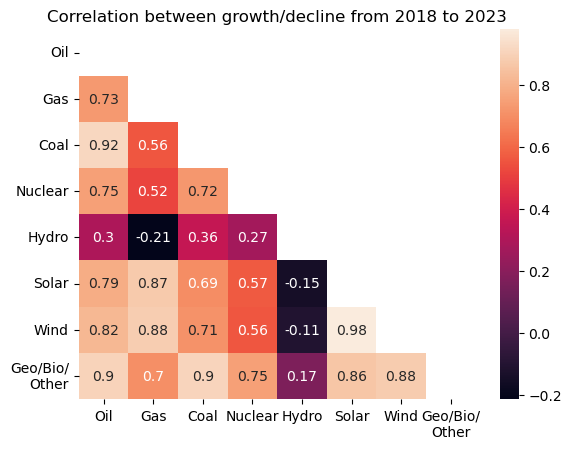

In [19]:
# Seaborn to get a more readable visualization of the correlation matrix.

corr= df.corr()
# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(df.corr(), annot=True, mask=matrix).set_title("Correlation between growth/decline from 2018 to 2023")

This is a quick and dirty analysis, and it comes with several limitations.

- Correlation does not imply causation. It is possible, for instance, that one energy source is substituting for another but that this substitution is drowned out by economic growth effects. In other words, if solar and wind were not available, coal and gas might have grown by even more. Whether this happens cannot readily be determined from just the EI data.
- Absolute growth in consumption is the metric chosen for evaulation, and this was done so as to give high-consumption countries more weight in the correlation. If percentage growth is used instead, very little correlation is found. I do not know the reason for this.

## Primary Energy Statistics

In [5]:
# Using the sheet name keys as defined above.
energy_list = {}
for i in range(len(keys)):
    energy_list[variables[i]] = np.array(dfs[keys[i]].loc[109,:].tolist()[1:-3])

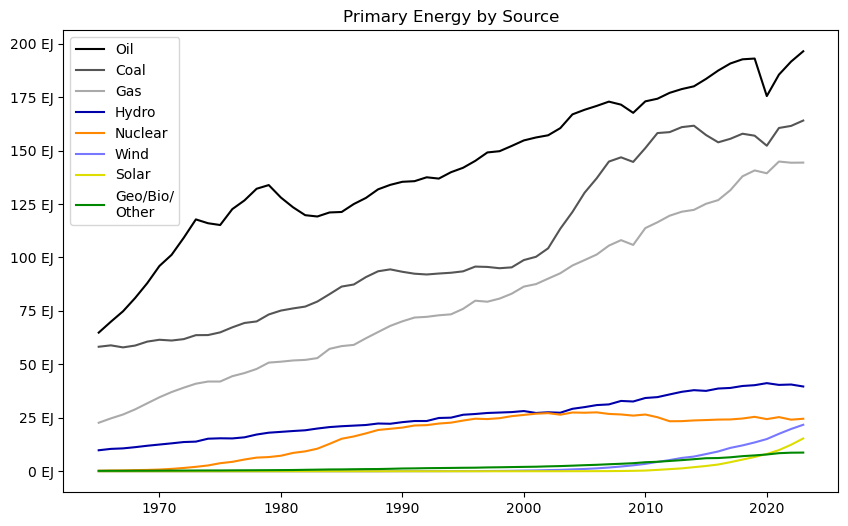

In [6]:
# Energy sources are placed in descending order of 2023 production.
variables_order  = ["Oil","Coal","Gas","Hydro","Nuclear","Wind","Solar","Geo/Bio/\nOther"]
colors = ["#000000","#555555","#AAAAAA","#0000AA","#FF8800","#7777FF","#DDDD00","#008800"]
axes = plt.figure(figsize=(10,6)).add_subplot(111)
years = range(1965,2024)

for i in range(len(variables)):
    plt.plot(years,energy_list[variables_order[i]],label=variables_order[i], color=colors[i])

plt.legend()

yticks = axes.get_yticks().tolist()[1:-1]
yticks_labels = [str(int(yticks[i]))+" EJ" for i in range(len(yticks))]
axes.yaxis.set_ticks(yticks)
axes.set_yticklabels(yticks_labels)
#axes.set_ylabel("Primary Energy")
plt.title("Primary Energy by Source")

plt.show()

## Primary Energy from Fossil Fuels

In [7]:
ff = energy_list["Oil"]+energy_list["Gas"]+energy_list["Coal"]
primary_energy = np.array(dfs["Primary energy cons - EJ"].loc[109,:].tolist()[1:-3])
ff_share = ff/primary_energy

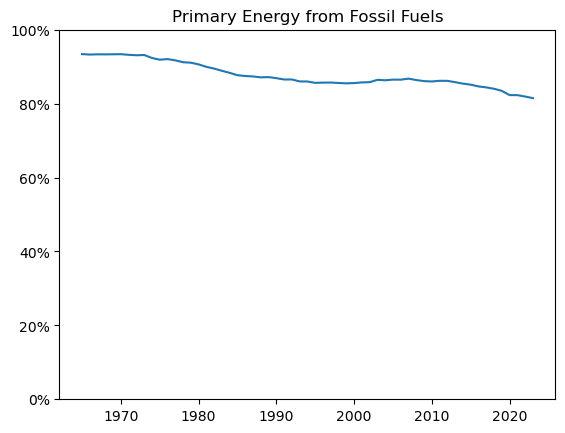

In [16]:
axes = plt.figure().add_subplot(111)
plt.plot(years,ff_share)

plt.ylim(0,1)

yticks = axes.get_yticks().tolist()
yticks_labels = [str(int(100*yticks[i]))+"%" for i in range(len(yticks))]
axes.yaxis.set_ticks(yticks)
axes.set_yticklabels(yticks_labels)

plt.title("Primary Energy from Fossil Fuels")
plt.show()

In [9]:
# How long would it take, extrapolating the rate of percentage transition from 1965 to 2023,
# to build a completely low-carbon energy system?

progress_per_year = (ff_share[0]-ff_share[-1])/(years[-1]-years[0])
time_to_zero = ff_share[-1] / progress_per_year
print("Zero fossil fuels in the year ",round(years[-1] + time_to_zero),".",sep="")

Zero fossil fuels in the year 2420.


## Electrification

In [24]:
# Notes on primary energy factor:
# https://www.energyinst.org/statistical-review/about

# Primary energy factors by year from 1965 to 2049
pef = [0.36 for i in range(35)] + [0.36+i*0.04/18. for i in range(18)] + [0.40+i*0.05/32. for i in range(32)]

electricity = np.array(dfs["Electricity Generation - TWh"].loc[108,:].tolist()[1:-3])
electricity_share = electricity*0.0036 / primary_energy[20:] / np.array(pef)[20:59]

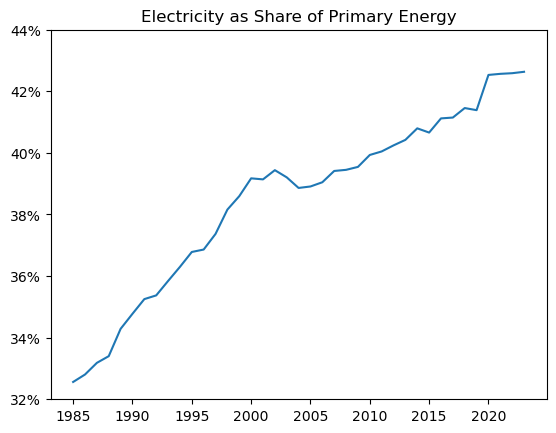

In [25]:
axes = plt.figure().add_subplot(111)
plt.plot(years[20:],electricity_share)

plt.ylim(0.32,0.44)

yticks = axes.get_yticks().tolist()
yticks_labels = [str(int(100*yticks[i]))+"%" for i in range(len(yticks))]
axes.yaxis.set_ticks(yticks)
axes.set_yticklabels(yticks_labels)

plt.title("Electricity as Share of Primary Energy")
plt.show()

In [12]:
# How long will it take to get to a 100% electricity system at the pace shown above?

progress_rate = (electricity_share[-1]-electricity_share[0])/(years[-1]-years[20])

print("100% electricity around the year ",round(years[-1]+(1-electricity_share[-1])/progress_rate),".",sep="")

100% electricity around the year 2239.
